# CarND Advanced Lane Lines Detection

## The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Imports

In [3]:
import matplotlib.image as mpimg
import numpy as np
import cv2
import matplotlib.pyplot as plt
from urllib.request import urlopen
import os
import pickle
import glob
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Camera Calibration

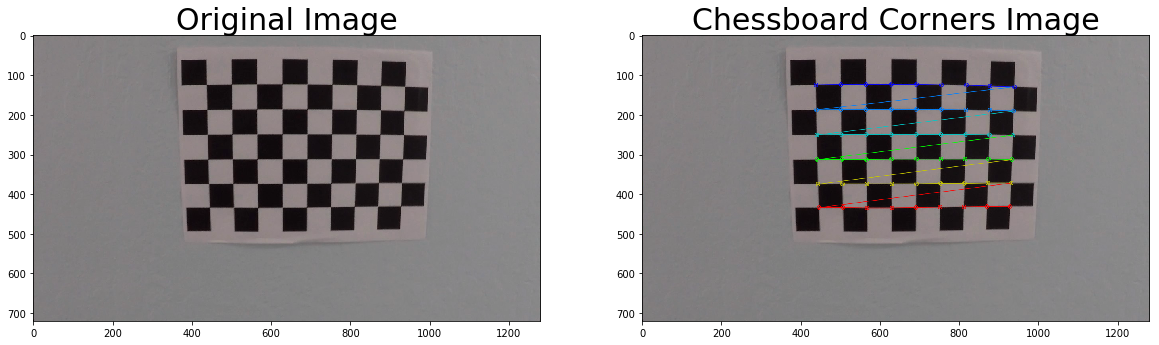

In [78]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
#z is zero coz board on flat image plane
objp = np.zeros((6*9,3), np.float32)
#mgrid returns coordinate value for given grid size and ill shape those coordinates back into 2 cols one for x an one for y.
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

for index,image in enumerate(images):
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners  (for an 8x6 board)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        objpoints.append(objp)
        #from https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        cv2.drawChessboardCorners(img, (9,6), corners2, ret)
        ax2.imshow(img)
        ax2.set_title('Chessboard Corners Image', fontsize=30)

### Calculating Distortion co-efficients

Text(0.5,1,'Undistorted Image')

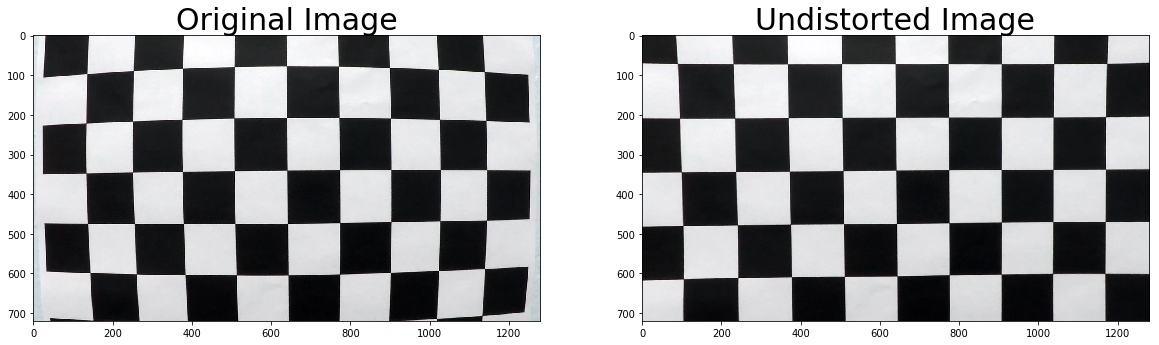

In [79]:
img = cv2.imread('camera_cal/calibration1.jpg')

img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

distortion_pickle = {}
distortion_pickle["mtx"] = mtx
distortion_pickle["dist"] = dist
pickle.dump( distortion_pickle, open( "cam_calibration.p", "wb" ) )

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('writeup_images/orginal_chess.jpg',img)
cv2.imwrite('writeup_images/Undistorted_chess.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Undistort raw images

In [4]:
def undistort_images(img):
    distor_pickle = pickle.load( open( "cam_calibration.p", "rb" ) )
    mtx = distor_pickle["mtx"]
    dist = distor_pickle["dist"]
    return cv2.undistort(img, mtx, dist, None, mtx)
    

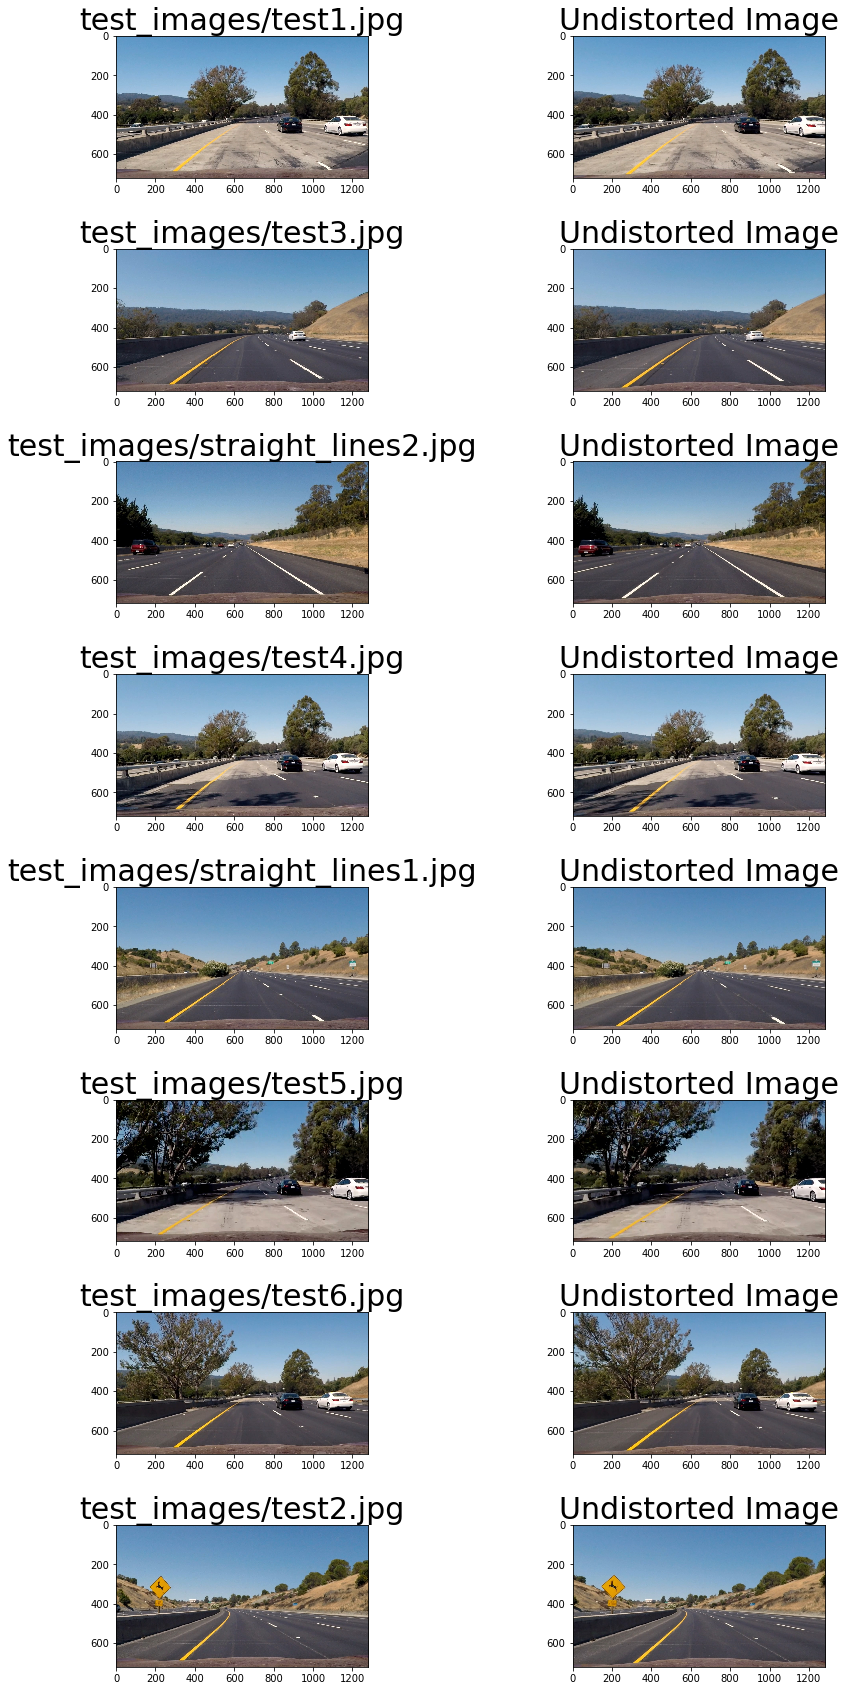

In [5]:
test_images = glob.glob('test_images/*.jpg')

f, ax = plt.subplots(8,2,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

for index,image in enumerate(test_images):
    org_image = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    ax[index,0].imshow(org_image)
    ax[index,0].set_title(image, fontsize=30)
    undistort_image = undistort_images(org_image)
    ax[index,1].imshow(undistort_image)
    ax[index,1].set_title('Undistorted Image', fontsize=30)
#     cv2.imwrite('writeup_images/orginal_test_image.jpg',org_image)
#     cv2.imwrite('writeup_images/Undistorted_test_image.jpg',undistort_image)

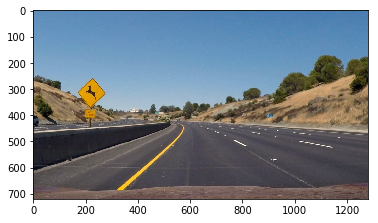

In [6]:
plt.imshow(org_image)

In [ ]:
#test2.jpg

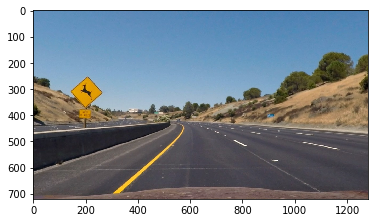

In [7]:
plt.imshow(undistort_image)

# Apply a perspective transform to rectify binary image ("birds-eye view").

In [8]:
def prespective_visualization(originalImage,left,apex_left,apex_right,right):
    return cv2.polylines(originalImage,np.int32(np.array([[left,apex_left,apex_right,right]])),True,(0,0,255),10)

In [9]:
def wraped_image(img):
    h,w = img.shape[:2]
    img_size = (img.shape[1],img.shape[0])
    #four src coordinates
    left=[150,720]
    right=[1250,720] 
    apex_left=[590,450] 
    apex_right=[700,450] 

    src=np.float32([left,apex_left,apex_right,right]) # Source Points for Image Warp
    dst= np.float32([[200 ,720], [200  ,0], [980 ,0], [980 ,720]]) # Destination Points for Image Warp
    
    example = img.copy()
    roi = prespective_visualization(example,left,apex_left,apex_right,right)
    
    #using these pts get prespective transform M, which is matrix returned by below function
    M = cv2.getPerspectiveTransform(src, dst)
    
    #could also get inv prespective transform by swapping these input pts to unwrap the img.
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #create wraped image -flags=cv2.INTER_LINEAR--> how to interpolate points pts which is filling the missing pts as it warps an img-- used linear interpolation.
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    
    return warped,M,Minv,roi

In [10]:
warped,M,Minv,roi = wraped_image(undistort_image)

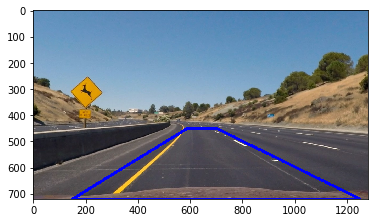

In [11]:
plt.imshow(roi)
# cv2.imwrite('prespective.jpg',roi)

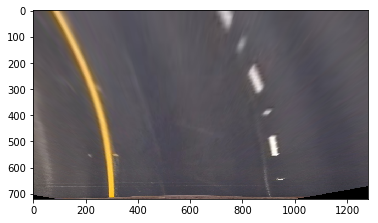

In [12]:
plt.imshow(warped)
# cv2.imwrite('warped.jpg',warped)

# Used color transforms, gradients, etc., to create a thresholded binary image.

In [13]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=3,thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return sxbinary

In [14]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_sobelxy = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    return sxbinary

In [15]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(arctan)
    sxbinary[(arctan > thresh[0]) & (arctan < thresh[1])] = 1  
    return sxbinary

In [16]:
ksize = 5 

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(warped, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(warped, sobel_kernel=ksize, thresh = (0.9, 1.3))

In [44]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

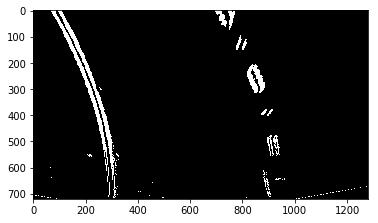

In [45]:
plt.imshow(combined, cmap='gray')

In [17]:
def colorspaces_binary(warped,colorspace,threshold,channel):
    color_img = cv2.cvtColor(warped, colorspace)
    channel_values = color_img[:,:,channel]
    binary_channel = np.zeros_like(channel_values)
    binary_channel[(channel_values > threshold[0]) & (channel_values <= threshold[1])] = 1
    return binary_channel
    
    

In [154]:
thresh = [100,255]

In [155]:
gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

Text(0.5,1,'grey_binary Image')

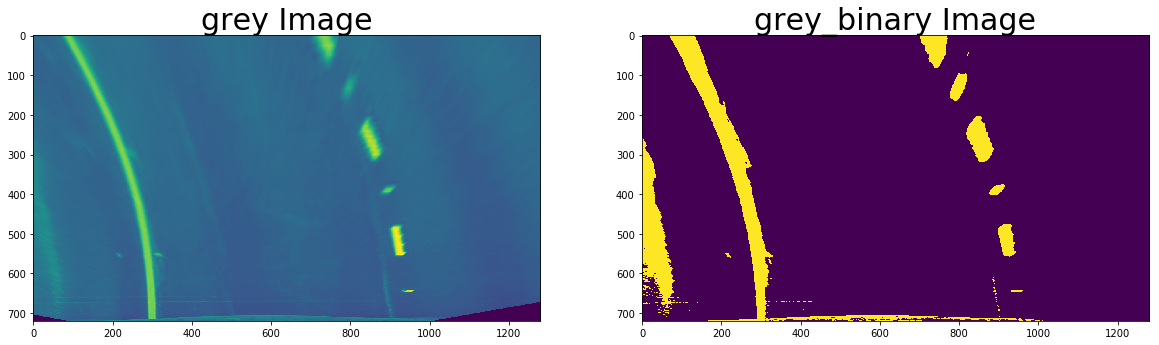

In [156]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(gray)
ax1.set_title('grey Image', fontsize=30)
ax2.imshow(binary)
ax2.set_title('grey_binary Image', fontsize=30)

In [157]:
R = warped[:,:,0]
G = warped[:,:,1]
B = warped[:,:,2]
binary_R = np.zeros_like(R)
binary_R[(R > thresh[0]) & (R <= thresh[1])] = 1
binary_G = np.zeros_like(G)
binary_G[(G > thresh[0]) & (G <= thresh[1])] = 1
binary_B = np.zeros_like(B)
binary_B[(B > thresh[0]) & (B <= thresh[1])] = 1

Text(0.5,1,'binary_R Image')

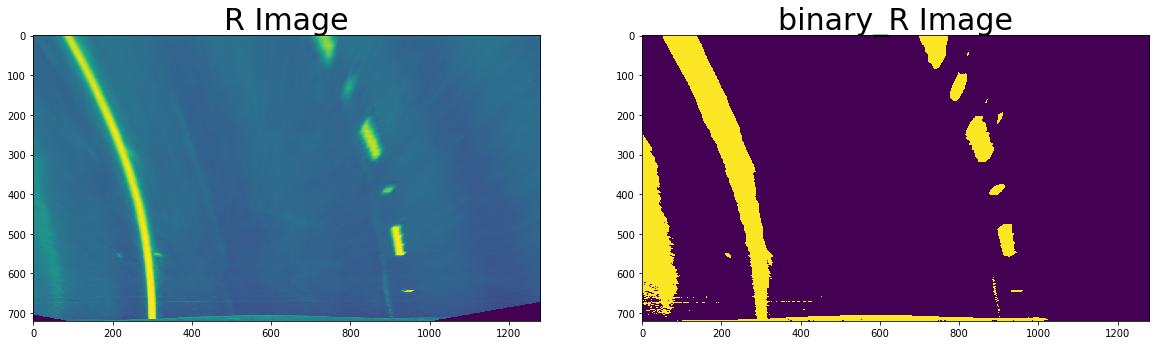

In [158]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(R)
ax1.set_title('R Image', fontsize=30)
ax2.imshow(binary_R)
ax2.set_title('binary_R Image', fontsize=30)

Text(0.5,1,'binary_G Image')

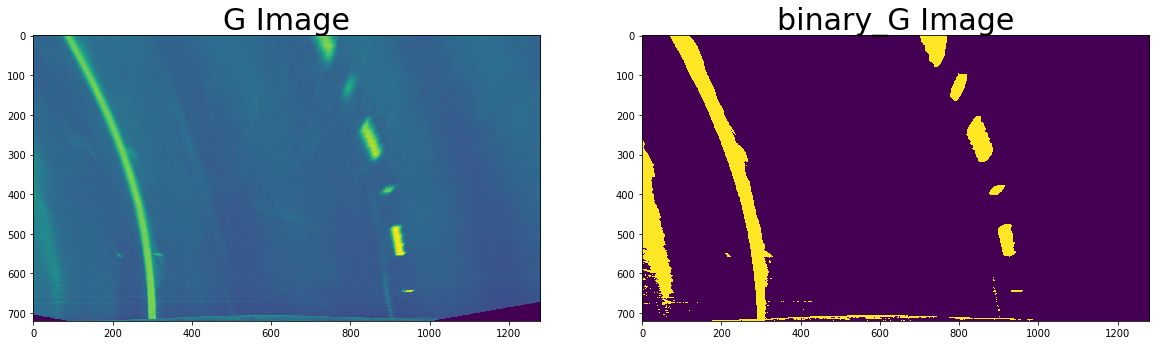

In [159]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(G)
ax1.set_title('G Image', fontsize=30)
ax2.imshow(binary_G)
ax2.set_title('binary_G Image', fontsize=30)

Text(0.5,1,'binary_B Image')

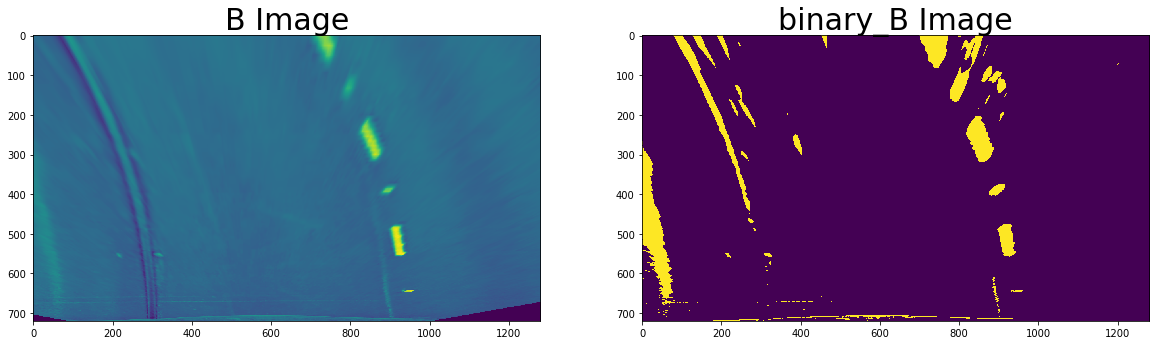

In [160]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(B)
ax1.set_title('B Image', fontsize=30)
ax2.imshow(binary_B)
ax2.set_title('binary_B Image', fontsize=30)

In [161]:
hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

In [162]:
S_binary = np.zeros_like(S)
S_binary[(S > thresh[0]) & (S <= thresh[1])] = 1

In [163]:
H_binary = np.zeros_like(H)
H_binary[(H > thresh[0]) & (H <= thresh[1])] = 1

In [164]:
L_binary = np.zeros_like(L)
L_binary[(L > thresh[0]) & (L <= thresh[1])] = 1

Text(0.5,1,'H_binary Image')

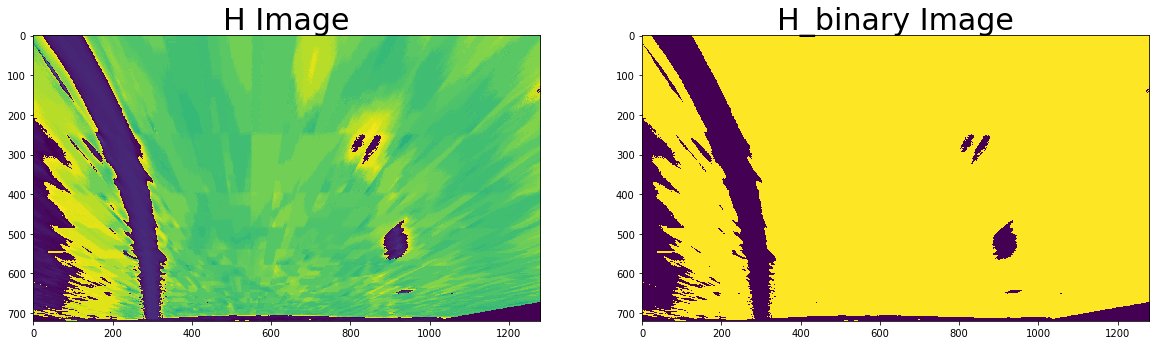

In [165]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(H)
ax1.set_title('H Image', fontsize=30)
ax2.imshow(H_binary)
ax2.set_title('H_binary Image', fontsize=30)

Text(0.5,1,'S_binary Image')

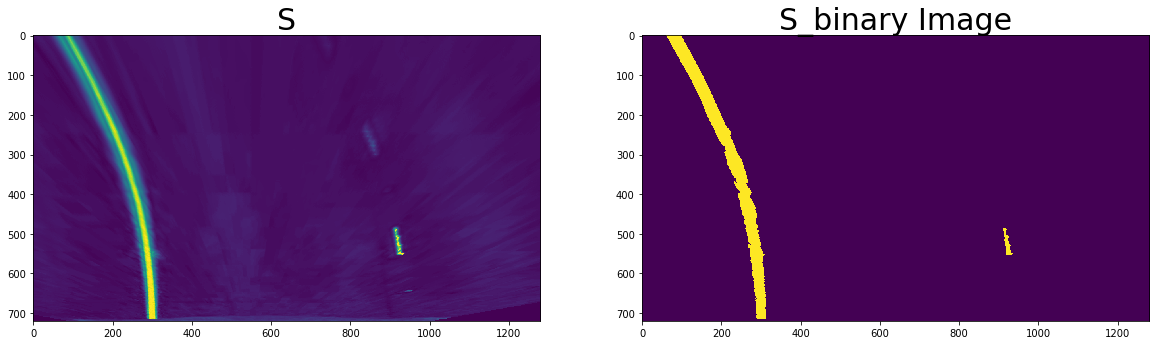

In [166]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(S)
ax1.set_title('S', fontsize=30)
ax2.imshow(S_binary)
ax2.set_title('S_binary Image', fontsize=30)

Text(0.5,1,'L_binary Image')

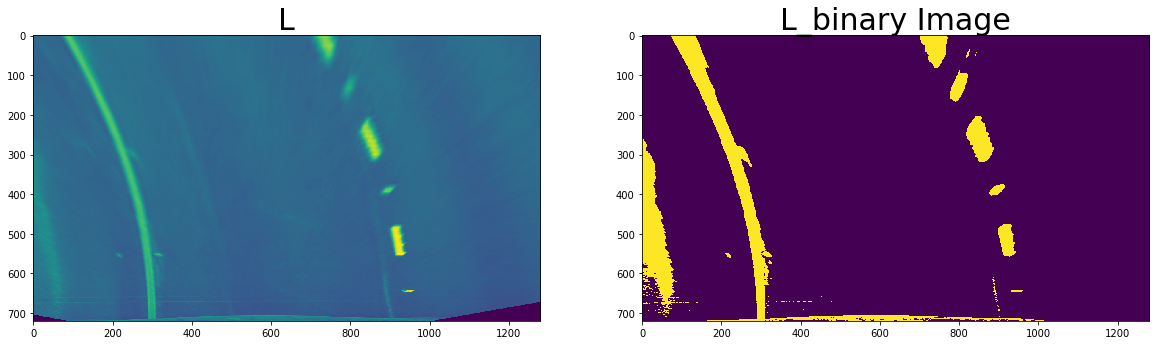

In [168]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(L)
ax1.set_title('L', fontsize=30)
ax2.imshow(L_binary)
ax2.set_title('L_binary Image', fontsize=30)

# combining different color spaces and sobel gradients

In [214]:
combined_binary = np.zeros_like(S_binary)
combined_binary[((S_binary==1)&(L_binary==1))| (gradx == 1)]=1

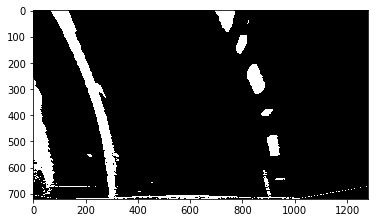

In [209]:
plt.imshow(combined_binary,cmap='gray')

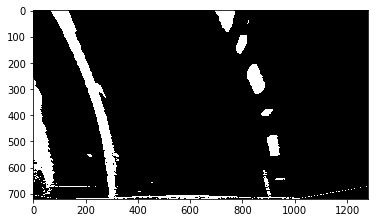

In [215]:
plt.imshow(combined_binary,cmap='gray')

# Complete preprocessing pipeline for raw images

In [18]:
def preprocessing_image(img):
    undistorted_image = undistort_images(img)
    warped_img,M,Minv,roi = wraped_image(undistorted_image)
    ksize = 3
    # Applying each of the thresholding functions
    gradx = abs_sobel_thresh(warped_img, orient='x', sobel_kernel=ksize, thresh=(10,150))
#     mag_binary = mag_thresh(warped_img, sobel_kernel=ksize, mag_thresh=(30, 100))
#     dir_binary = dir_threshold(warped_img, sobel_kernel=ksize, thresh = (0.9, 1.3))
    #colorspaces
    threshold = [100,255]
    L_binary = colorspaces_binary(warped_img,cv2.COLOR_RGB2HLS,threshold,1)
    S_binary = colorspaces_binary(warped_img,cv2.COLOR_RGB2HLS,threshold,2)
    #combining colorspaces and sobel threshold gradients
    combined_binary = np.zeros_like(S_binary)
    combined_binary[((S_binary==1)&(L_binary==1))| (gradx == 1)]=1
    return combined_binary,Minv

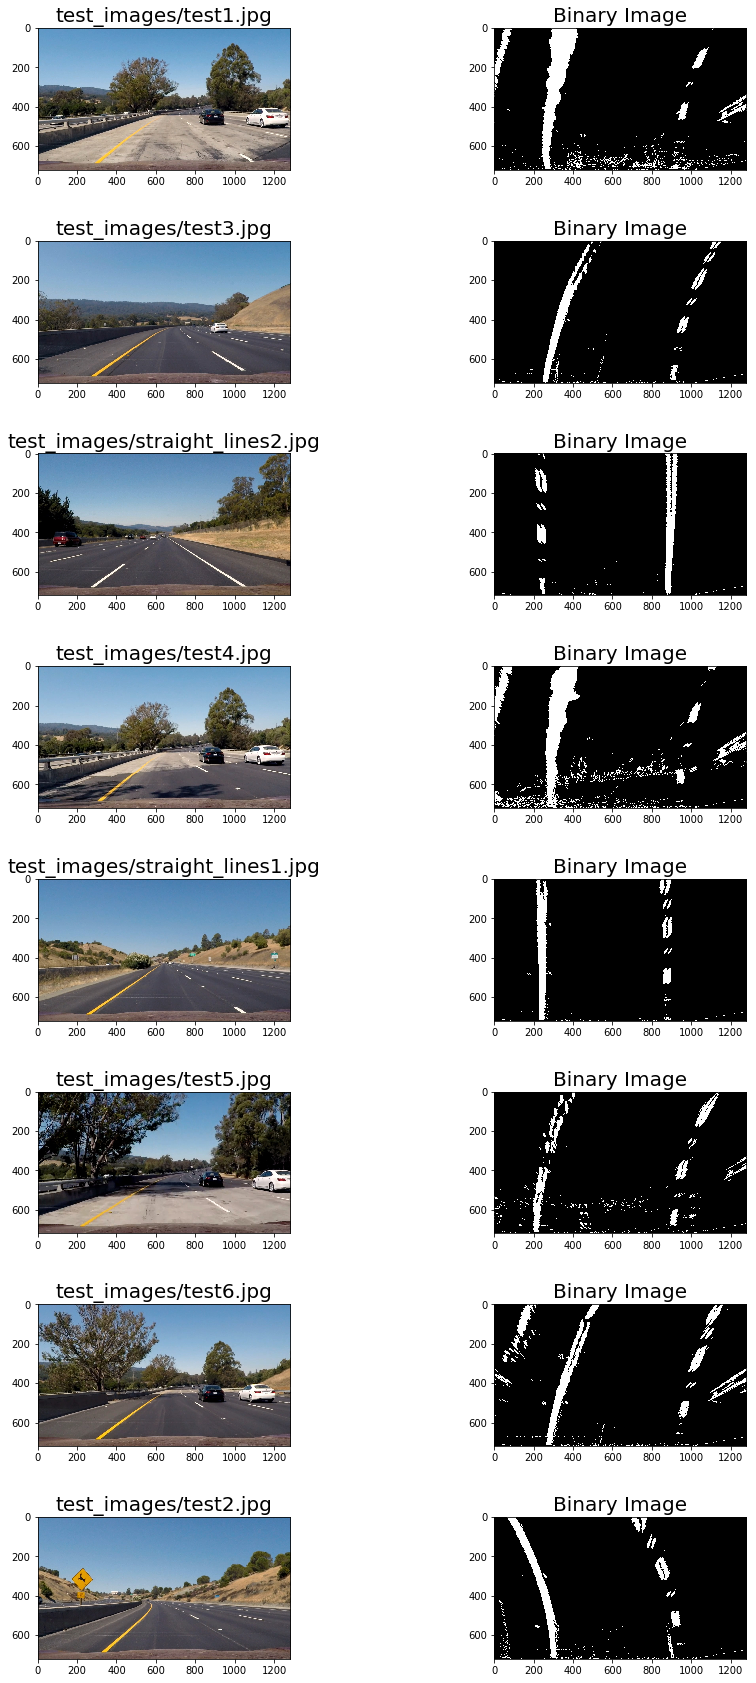

In [19]:
test_images = glob.glob('test_images/*.jpg')

f, ax = plt.subplots(8,2,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

for index,image in enumerate(test_images):
    org_image = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    ax[index,0].imshow(org_image)
    ax[index,0].set_title(image, fontsize=20)
    binary_image,Minv = preprocessing_image(org_image)
    ax[index,1].imshow(binary_image,cmap='gray')
    ax[index,1].set_title('Binary Image', fontsize=20)
    

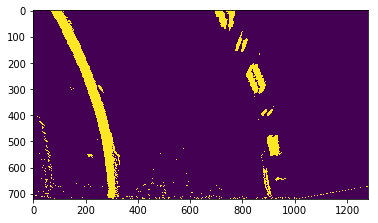

In [20]:
plt.imshow(binary_image)
# plt.imsave("writeup_images/binary_image.png", binary_image, cmap = 'gray')

# Histogram and lane line detection

In [21]:
def Histogram(binary_image):
    bottom_half = binary_image[binary_image.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    return histogram

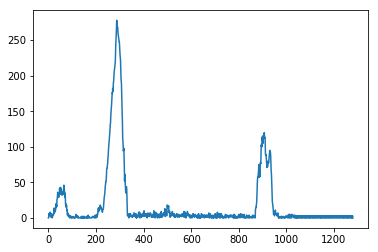

In [22]:
plt.plot(Histogram(binary_image))

In [39]:
def sliding_windows(binary_image):
    histogram = Histogram(binary_image)
    out_img = np.dstack((binary_image, binary_image, binary_image))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    window_height = np.int(binary_image.shape[0]//nwindows)
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_image.shape[0] - (window+1)*window_height
        win_y_high = binary_image.shape[0] - window*window_height
        ### four boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ###Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) 
                        & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) 
                        & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
    return left_fit,right_fit,left_lane_inds,right_lane_inds,out_img,leftx, lefty, rightx, righty,out_img

In [40]:
left_fit,right_fit,left_lane_inds,right_lane_inds,out_img,leftx, lefty, rightx, righty,out_img=sliding_windows(binary_image)

In [43]:
def plot_sliding_windows(left_fit,right_fit,out_img,imge):
    # Generate x and y values for plotting
    ploty = np.linspace(0, imge.shape[0]-1, imge.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    return out_img,left_fitx, right_fitx, ploty

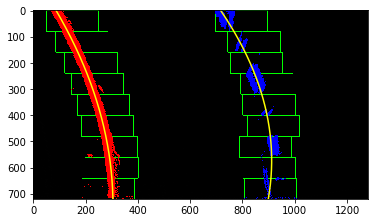

In [42]:
out_img,left_fitx, right_fitx, ploty = plot_sliding_windows(left_fit,right_fit,out_img,binary_image)

plt.imshow(out_img)

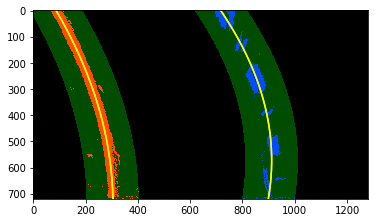

In [32]:
def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Fit new polynomials
    sl,left_fitx, right_fitx, ploty = plot_sliding_windows(leftx, lefty, rightx, righty, out_img,binary_warped)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_image,left_fit,right_fit)

# View your output
plt.imshow(result)

# Unwraping and plotting on the image

In [44]:
def draw_lines(orginal_image,binary_image,left_fit,right_fit,Minv):
    #image to draw lines 
    warp_zero = np.zeros_like(binary_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    #drawing lane on wraped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    h,w = binary_image.shape
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(orginal_image, 1, newwarp, 0.5, 0)
    return result

In [45]:
line_output = draw_lines(org_image,binary_image,left_fit,right_fit,Minv)

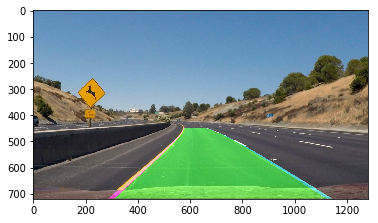

In [46]:
plt.imshow(line_output)

# Determine the curvature of the lane and vehicle position with respect to center

In [47]:
def measure_curvature(binary_image,left_fit,right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    car_position= binary_image.shape[1]/2
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    #####Implementing the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+((2*left_fit[0]*y_eval)+left_fit[1])**2)**1.5)/np.absolute(2*left_fit[0])  ## the calculation of the left line 
    right_curverad = ((1+((2*right_fit[0]*y_eval)+right_fit[1])**2)**1.5)/np.absolute(2*right_fit[0])  ## the calculation of the right line 
    
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    actual_position= (left_lane_bottom+ right_lane_bottom)/2
    
    distance= (car_position - actual_position)* xm_per_pix
    
    # Now our radius of curvature is in meters
    return (left_curverad + right_curverad)/2, distance
    
    

# Complete pipline for advanced lane detection

In [48]:
def pipeline(original_image):
    binary_image,Minv = preprocessing_image(original_image)
    left_fit,right_fit,left_lane_inds,right_lane_inds,out_img,leftx, lefty, rightx, righty,out_img=sliding_windows(binary_image)
    line_output = draw_lines(original_image,binary_image,left_fit,right_fit,Minv)
    radius,distance = measure_curvature(binary_image,left_fit,right_fit)
    cv2.putText(line_output,"Radius of Curvature is " + str(int(radius))+ "m", (100,100), cv2.FONT_HERSHEY_COMPLEX, 1, (255,255,0),2)
    cv2.putText(line_output,"Distance from center is {:2f}".format(distance)+ "m", (100,150), cv2.FONT_HERSHEY_COMPLEX, 1, (255,255,0),2)
    return line_output

# visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

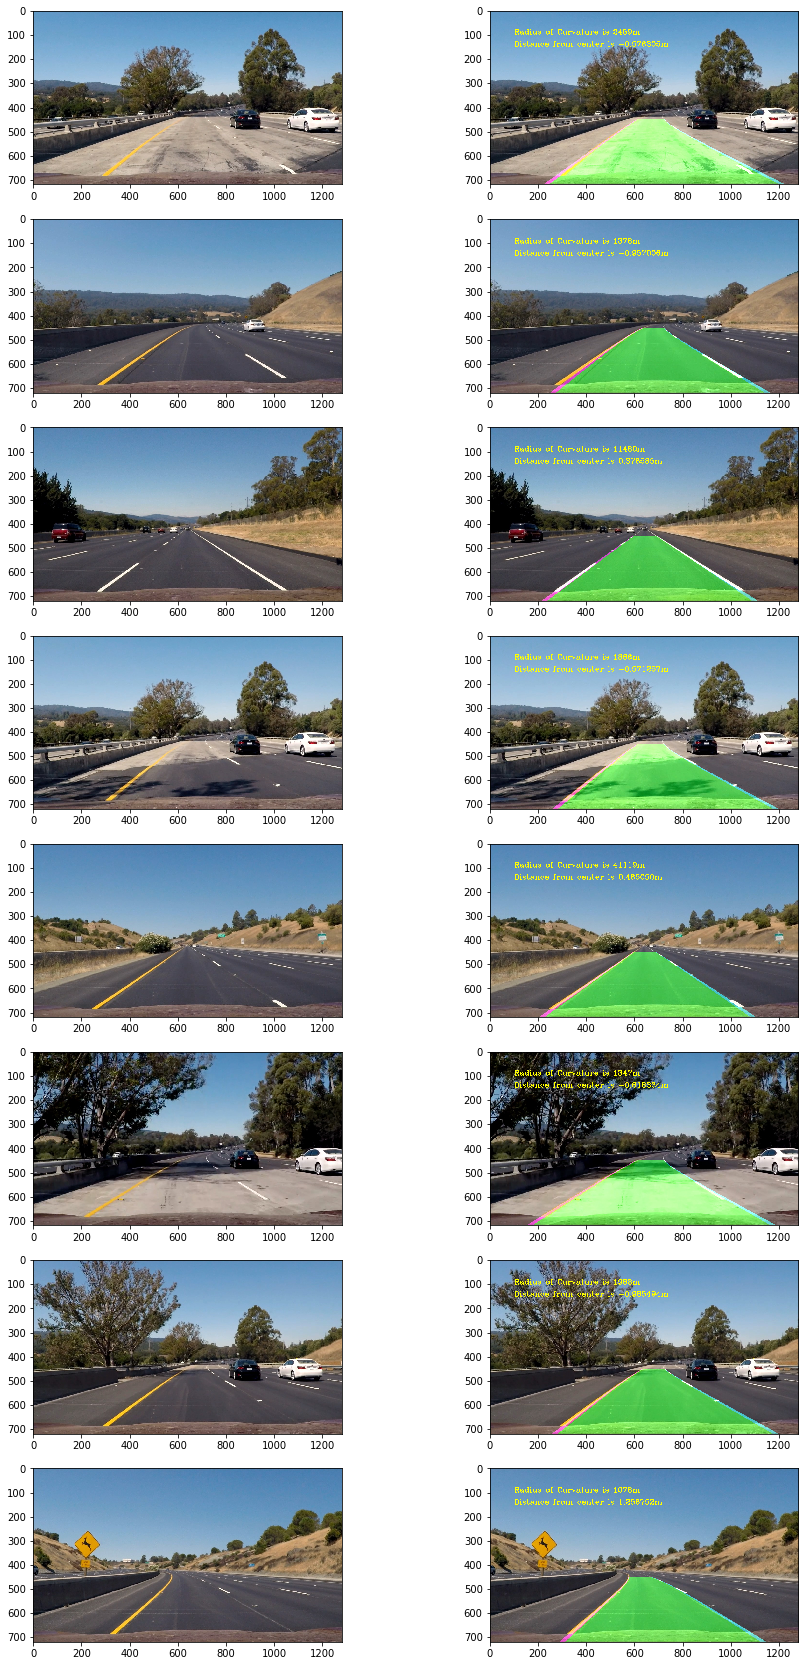

In [70]:
f, axes= plt.subplots(8,2,figsize=(15,30))

org_images = glob.glob('test_images/*.jpg') # Reading Images from test_images folder

for index, image in enumerate(org_images):
    orginal_image= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    final_output=pipeline(orginal_image)
    cv2.imwrite('output_images/'+str(index)+'.jpg', cv2.cvtColor(final_output,cv2.COLOR_BGR2RGB))
    axes[index,0].imshow(orginal_image)
    axes[index,1].imshow(final_output)


# Applying advanced lane detection pipeline on the video file. 

In [49]:
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:14<00:00,  5.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 57s, sys: 18.1 s, total: 2min 15s
Wall time: 4min 17s


In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

# Applying advanced lane detection pipeline on the challenge_video file.

In [73]:
challenge_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
video_clip2 = clip2.fl_image(pipeline) #NOTE: this function expects color images!!
%time video_clip2.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:44<00:00,  4.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 49 s, sys: 7.63 s, total: 56.7 s
Wall time: 1min 47s


In [74]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# Applying advanced lane detection pipeline on the harder_challenge_video file

In [75]:
harder_challenge_video_output = 'harder_challenge_video_output.mp4'
clip3 = VideoFileClip("harder_challenge_video.mp4")
video_clip3 = clip3.fl_image(pipeline) #NOTE: this function expects color images!!
%time video_clip3.write_videofile(harder_challenge_video_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [05:13<00:00,  4.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 2min 16s, sys: 18.2 s, total: 2min 35s
Wall time: 5min 18s


In [76]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video_output))